In [1]:
import networkx as nx
import pygraphviz as pgv
import matplotlib.pyplot as plt

In [2]:
G = pgv.AGraph()
nlist = "A B C D E".split()
a, b = "A A B", "B C D"
elist = zip(a.split(), b.split())

G.add_nodes_from(nlist)
G.add_edges_from(elist)
G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="blue", len="1.0", width="2.0")

print(G.edge_attr)
# returns {'color': 'red', 'width': '', 'len': '2.0'}

# add new edge with custom length (all others have length=2.0):
G.add_edge("C", "E", len="6.0", color="blue", width="2.0")

In [3]:
G.draw("test.png", format='png', prog='neato')

In [4]:
edges = [(1, 2, 1), (2, 3, 2), (3, 4, 1), (1, 3, 2)]

G = nx.Graph()

for start, end, length in edges:
    # You can attach any attributes you want when adding the edge
    G.add_edge(start, end, len=length)


In [5]:
nx.spring_layout(G, weight='length')

{1: array([ 0.66193095,  0.37574351]),
 2: array([ 0.01110841,  0.76106003]),
 3: array([-0.08099392, -0.13680354]),
 4: array([-0.59204544, -1.        ])}

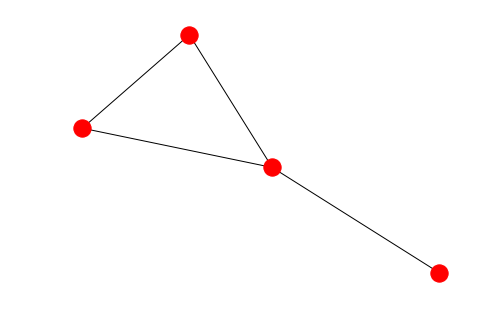

In [6]:
nx.draw(G, prog='neato')
plt.show()

In [7]:
G = pgv.AGraph()

In [8]:
G.add_node('a')

In [9]:
G.add_edge('a', 'c')
G.add_edge('c','d')

In [10]:
G.get_edge('a','c').attr['len'] = '2.0'
G.get_edge('c','d').attr['len'] = '11.0'

In [11]:
G.draw("g1.png", format='png', prog='neato')

In [12]:
G2 = pgv.AGraph()

G2.add_edge('a','c')
G2.add_edge('c','d')

G2.get_edge('a','c').attr['len'] = '2.0'
G2.get_edge('c','d').attr['len'] = '2.0'

In [13]:
G2.draw("g2.png", prog='neato')

In [14]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [15]:
lap1 = nx.spectrum.laplacian_spectrum(nx.drawing.nx_agraph.from_agraph(G))

In [16]:
lap2 = nx.spectrum.laplacian_spectrum(nx.drawing.nx_agraph.from_agraph(G2))

In [17]:
print(lap1)
print(lap2)

[  3.92505363e-17   1.00000000e+00   3.00000000e+00]
[  3.92505363e-17   1.00000000e+00   3.00000000e+00]


In [18]:
k1 = select_k(lap1)
k2 = select_k(lap2)
k = min(k1, k2)

print(k1)
print(k2)

similarity = sum((lap1[:k] - lap1[:k])**2)

3
3


In [19]:
print(similarity)

0.0


In [20]:
# From https://github.com/hhchen1105/networkx_addon/blob/master/similarity/simrank.py

"""
Implement SimRank similarity
"""
#    Copyright (C) 2004-2010 by
#    Hung-Hsuan Chen <hhchen@psu.edu>
#    All rights reserved.
#    BSD license.
#    NetworkX:http://networkx.lanl.gov/.
import copy
import sys
import networkx as nx
from collections import defaultdict
__author__ = """Hung-Hsuan Chen (hhchen@psu.edu)"""
__all__ = ['simrank']

def simrank(G, c=0.9, max_iter=100, remove_neighbors=False, remove_self=False, dump_process=False):
  """Return the SimRank similarity between nodes
  Parameters
  -----------
  G : graph
    A NetworkX graph
  c : float, 0 < c <= 1
    The number represents the relative importance between in-direct neighbors
    and direct neighbors
  max_iter : integer
    The number specifies the maximum number of iterations for simrank
    calculation
  remove_neighbors: boolean
    if true, the similarity value between neighbor nodes is set to zero
  remove_self : boolean
    if true, the similarity value between a node and itself is set to zero
  dump_process: boolean
    if true, the calculation process is dumped
  Returns
  -------
  simrank: dictionary of dictionary of double
    if simrank[i][j] = k, this means the SimRank similarity
    between node i and node j is k
  Examples
  --------
  >>> G=nx.Graph()
  >>> G.add_edges_from([(0,7), (0,1), (0,2), (0,3), (1,4), (2,4), (3,4), (4,5), (4,6)])
  >>> networkx_addon.similarity.simrank(G)
  Notes
  -----
  References
  ----------
  [1] G. Jeh and J. Widom.
  SimRank: a measure of structural-context similarity.
  In KDD'02 pages 538-543. ACM Press, 2002.
  """
  if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
    raise Exception("simrank() not defined for graphs with multiedges.")

  if G.is_directed():
    raise Exception("simrank() not defined for directed graphs.")

  sim_old = defaultdict(list)
  sim = defaultdict(list)
  for n in G.nodes():
    sim[n] = defaultdict(int)
    sim[n][n] = 1
    sim_old[n] = defaultdict(int)
    sim_old[n][n] = 0

  # calculate simrank
  for iter_ctr in range(max_iter):
    if _is_converge(sim, sim_old):
      break
    sim_old = copy.deepcopy(sim)
    for i, u in enumerate(G.nodes()):
      if dump_process:
        sys.stdout.write("\r%d : % d / %d" % (iter_ctr, i, G.number_of_nodes()))
      for v in G.nodes():
        if u == v:
          continue
        s_uv = 0.0
        for n_u in G.neighbors(u):
          for n_v in G.neighbors(v):
            s_uv += sim_old[n_u][n_v]
        
        len_u = sum(1 for _ in G.neighbors(u))
        len_v = sum(1 for _ in G.neighbors(v))
        
        sim[u][v] = (c * s_uv / (len_u * len_v)) \
            if len_u * len_v > 0 else 0
    if dump_process:
      print("")

  if remove_self:
    for m in G.nodes():
      G[m][m] = 0

  if remove_neighbors:
    for m in G.nodes():
      for n in G.neighbors(m):
        sim[m][n] = 0

  return sim

def _is_converge(s1, s2, eps=1e-4):
  for i in s1.keys():
    for j in s1[i].keys():
      if abs(s1[i][j] - s2[i][j]) >= eps:
        return False
  return True

In [21]:
s1 = simrank(nx.drawing.nx_agraph.from_agraph(G))
s2 = simrank(nx.drawing.nx_agraph.from_agraph(G2))

In [22]:
for index in s1:
    print(s1[index])

defaultdict(<class 'int'>, {'a': 1, 'c': 0.0, 'd': 0.9})
defaultdict(<class 'int'>, {'c': 1, 'a': 0.0, 'd': 0.0})
defaultdict(<class 'int'>, {'d': 1, 'a': 0.9, 'c': 0.0})


In [23]:
for index in s2:
    print(s2[index])

defaultdict(<class 'int'>, {'a': 1, 'c': 0.0, 'd': 0.9})
defaultdict(<class 'int'>, {'c': 1, 'a': 0.0, 'd': 0.0})
defaultdict(<class 'int'>, {'d': 1, 'a': 0.9, 'c': 0.0})


In [24]:
import graphsim as gs
import numpy as np

In [25]:
nxG = nx.drawing.nx_agraph.from_agraph(G)

In [26]:
gs.ascos(nxG)

(NodeView(('a', 'c', 'd')), array([[ 1.        ,  0.9       ,  0.68059145],
        [ 0.75626615,  1.        ,  0.75626615],
        [ 0.68059145,  0.9       ,  1.        ]]))

In [27]:
V = 3 # number of nodes
D = 2 # dimensionality

positions = np.random.rand(V, D)
differences = positions[:, None, :] - positions[None, :, :]
distances = np.sqrt(np.sum(differences**2, axis=-1)) # euclidean

In [28]:
print(distances)

[[ 0.          0.0567229   0.13162267]
 [ 0.0567229   0.          0.08843139]
 [ 0.13162267  0.08843139  0.        ]]


In [29]:
graph = nx.from_numpy_matrix(distances, create_using=nx.DiGraph())

In [30]:
nx.draw(graph)

In [32]:
plt.show()